# Goal
Given a cropped image (or multiple iamages or video stream) of video traffic signs, our goal is to recognise what type(or class/category) of traffic sign it contains. 

- This assumes that any image has exactly one sign. 
- The dataset used does not have training examples for *No traffic sign* condition (or background class).

Traffic sign detection and recognition is usually done in two phases. 

![Traffic sign detection and recognition](https://www.pyimagesearch.com/wp-content/uploads/2019/11/traffic_sign_classification_phases.jpg)

Phase-1 is the traffic sign deetction part, wherein, in a given image, our goal is to detect the location of the traffic sign(s). This is also known as localization. This information is used to create a closely cropped image of the detected traffic sign, and then fed to the phase-2 of the algorithm whose job is to recognise what traffic sign class / category the given image belongs to.

## Downloading dataset

In [0]:
! git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


## Importing libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import pickle
import pandas as pd
import random

# Setting random seed for reproducibility
np.random.seed(0)

# Magic command to ensure notebook juses Tensorflow 1.x instead of 2.x
%tensorflow_version 1.x

Using TensorFlow backend.


## Reading and exploring dataset

In [0]:
# Read training data
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)

# Read validation data
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)

# Read testing data
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

# checking the datatype of data read from pickle file
print(type(train_data)) # Dictionary
print(train_data.keys())

x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>
dict_keys(['coords', 'labels', 'features', 'sizes'])


---
Now that we have the training, validation and testing datasets, it is a good idea to have an idea about their size.

In [0]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


We expect to have same number of data points for the target variable

In [0]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(34799,)
(4410,)
(12630,)


---
Other than images and their labels, we have another file that maps the integer class IDs to actual traffic sign names. Reading this file...

In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

---
Peeking through 5 random images from each of the 43 classes

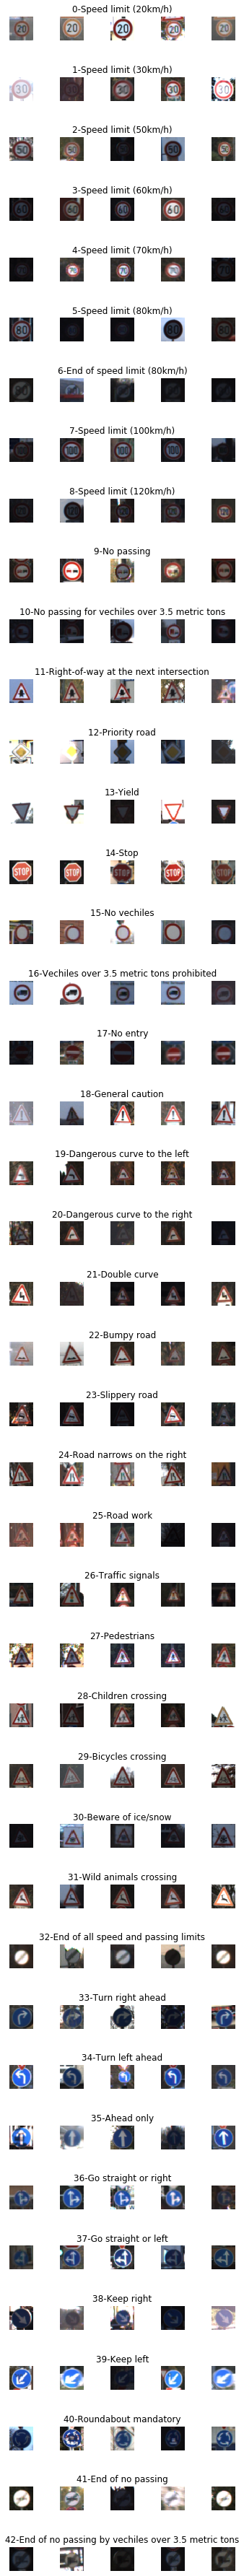

In [0]:
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
  for j,row in data.iterrows():
    x_selected = x_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i ==2:
      axs[j][i].set_title(str(j)+'-'+row['SignName'])
      num_of_samples.append(len(x_selected))

While training neural networks, it is usually preferred to have equal number of training examples for each of the classes to have better network performance. 

Creating a bar plot to show the frequency of each of the classes to see if our dataset is uniform or not...

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


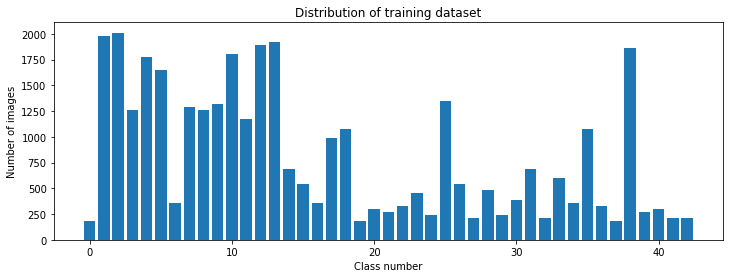

In [0]:
# Number of samples for every class
print(num_of_samples)

plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title('Distribution of training dataset')
plt.xlabel('Class number')
plt.ylabel('Number of images')
plt.show()

We do see that our dataset does not have equal (or approximately equal) number of images for all classes. In fact, we have for many of the classes, we have lower than 200 images per class.

## Performing preprocessing on images



(34799, 32, 32, 3)
36


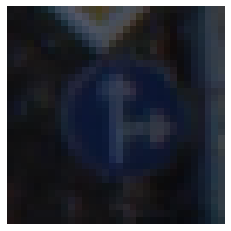

In [0]:
import cv2

plt.imshow(x_train[1000])
plt.axis('off')
print(x_train.shape)
print(y_train[1000])

### Converting to grayscale

(32, 32)


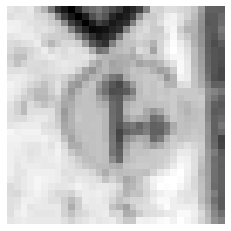

In [0]:
# Grayscale
def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = grayscale(x_train[1000])
plt.imshow(img, cmap='gray_r')
plt.axis('off')
print(img.shape)

### Performing histogram equalization
Histogram equalization is a technique used to improve the contrast in images. Though, improving contrast does not necessarily mean increasing the contrast.

(-0.5, 31.5, 31.5, -0.5)

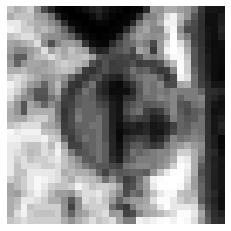

In [0]:
def equalize(img):
  return cv2.equalizeHist(img)

img = equalize(img)
plt.imshow(img, cmap='gray_r')
plt.axis('off')

### Applying preprocessing to images
1. Change of color space from RGB to grayscale
2. Hsitogram equalization
3. Normalization



In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  # Normalization
  img = img/255.
  return img

x_train = np.array(list(map(preprocessing, x_train)))
x_val = np.array(list(map(preprocessing, x_val)))
x_test = np.array(list(map(preprocessing, x_test)))

(34799, 32, 32)


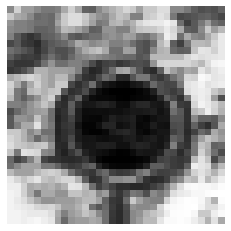

In [0]:
plt.imshow(x_train[random.randint(0, len(x_train)-1)], cmap='gray_r')
plt.axis('off')
print(x_train.shape)

## Preparing data for the model

### Reshaping tensors to appropriate shape

In [0]:
# Reshaping from [Batch-size, 32, 32] to [Batch-size, 32, 32, 1]
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 1)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


### Setting up data generator with image augmentation

In [0]:
datagen = ImageDataGenerator(rotation_range=10,
                   height_shift_range=0.1,
                   width_shift_range=0.1,
                   zoom_range=(0.8,1.2),
                   shear_range=0.1
                   )
datagen.fit(x_train)

x_batch shape: (32, 32, 32, 1)
y_batch shape: (32,)


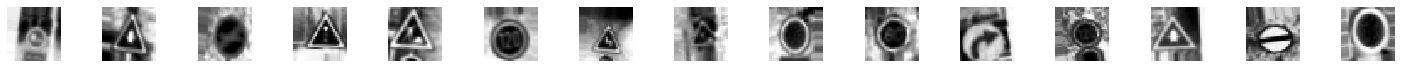

In [0]:
# Reading data in batches and augmenting them on the fly
batches = datagen.flow(x_train, y_train, batch_size=32, shuffle=True) # Can use flow_from_directory if images are present on disk and not yet in memory
x_batch, y_batch = next(batches)

print('x_batch shape:', x_batch.shape) # NOTE that the # of images == batch_size provided to the flow method. Implies, that the returned batch has only BATCH_SIZE no. of images after applying augmentation
print('y_batch shape:', y_batch.shape)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32,32), cmap='gray_r')
  axs[i].axis('off')

### One hot encoding for target variable

In [0]:
# One-hot encoding our labels
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# Defining the model

In [0]:
# Defining our model
def leNet_model():
  model = Sequential()
  model.add(Conv2D(16, (5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(32, (5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.5))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
model = leNet_model()
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0        

# Training

In [0]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), epochs=15, steps_per_epoch=3125, validation_data=(x_val, y_val), verbose=1, shuffle=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/15





3125/3125 [==============================] - 67s 22ms/step - loss: 1.0223 - acc: 0.6930 - val_loss: 0.1013 - val_acc: 0.9739
Epoch 2/15
3125/3125 [==============================] - 59s 19ms/step - loss: 0.3380 - acc: 0.8931 - val_loss: 0.0601 - val_acc: 0.9823
Epoch 3/15
3125/3125 [==============================] - 59s 19ms/step - loss: 0.2452 - acc: 0.9238 - val_loss: 0.0336 - val_acc: 0.9902
Epoch 4/15
3125/3125 [==============================] - 60s 19ms/step - loss: 0.2106 - acc: 0.9345 - val_loss: 0.0548 - val_acc: 0.9816
Epoch 5/15
3125/3125 [==============================] - 60s 19ms/step - loss: 0.1854 - acc: 0.9433 - val_loss: 0.0259 - val_acc: 0.9921
Epoch 6/15
3125/3125 [==============================] - 60s 19ms/step - loss: 0.1744 - acc: 0.9466 - val_loss: 0.0250 - val_acc: 0.9923
Epoch 7/15
3125/3125 [==============================] - 60s 19ms/step - loss: 0.15

Text(0.5, 0, 'epochs')

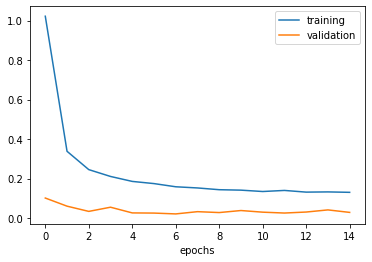

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

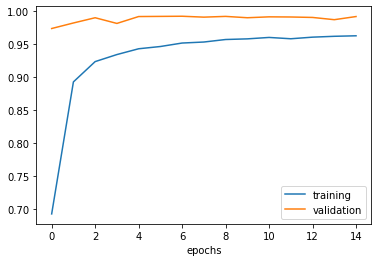

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.xlabel('epochs')

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.08592448257590918
Test accuracy: 0.977988915299954


---